In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize=(9, 3)
else:
    figsize=(14, 4)

from util import util
import os
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras import regularizers

# Load data
data_folder = os.path.join('..', 'data')
data = util.load_communities_data(data_folder)

# Standardize and separate train and test data
attributes, target = data.columns[3:-1], data.columns[-1]
nf = [a for a in attributes if a != 'race'] + [target]

tr_frac = 0.8 # 80% data for training
tr_sep = int(len(data) * tr_frac)
tmp = data.iloc[:tr_sep]

sdata = data.copy()
sdata[nf] = (sdata[nf] - tmp[nf].mean()) / (tmp[nf].std())

sdata[attributes] = sdata[attributes].astype(np.float32)
sdata[target] = sdata[target].astype(np.float32)

tr = sdata.iloc[:tr_sep]
ts = sdata.iloc[tr_sep:]

2023-11-12 13:22:37.388229: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 13:22:37.423393: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 13:22:37.423425: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 13:22:37.423448: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 13:22:37.429559: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 13:22:37.429934: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Constrained ML via Lagrangians

## Fairness as a Constraint

**Let's recap our goals:**

We want to train an accurate regressor ($L = \operatorname{MSE}$):

$$
\operatorname{argmin}_{\theta} \mathbb{E}_{x, y \sim P(X, Y)}\left[ L(y, f(x, \theta)) \right]
$$

We want to measure fairness via the DIDI:

$$
\operatorname{DIDI}(y) = \sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

...And we want the DIDI to be low, e.g.:

$$
\operatorname{DIDI}(y) \leq \varepsilon
$$

## Fairness as a Constraint

**We can use this information to re-state the training problem**

$$
\operatorname{argmin}_{\theta} \left\{ \mathbb{E}\left[ L(y, f(x, \theta)) \right] \mid \operatorname{DIDI}(f(x, \theta)) \leq \varepsilon \right\}
$$

* Training is now a _constrained optimization_ problem
* We require the DIDI _for ML output_ to be within acceptable levels

After training, the constraint will be _distilled_ in the model parameters

**We are requiring constraint satisfaction _on the training set_**

...Meaning that we'll have _no satisfaction guarantee on unseen examples_

* This is suboptimal, but doing better is very difficult
* ...Since our constraint is defined (conceptually) _on the whole distribution_

We'll trust the model to generalize well enough

<div class=big>How to account for the constraint at training time?</div>

<center>There's more then one method: we'll see the most famous one in ML</center>

## Constrained Machine Learning

**Let's consider a ML problem with _constrained output_**

In particular, let's focus on problems in the form:
$$
\text{argmin}_{\theta} \left\{ L(\hat{y}) \mid g(\hat{y}) \leq 0 \right\} \quad\text{ with: } \hat{y} = f(x, \theta)
$$

Where:

* $L$ is the loss (the notation omits ground truth label for sake of simplicity)
* $x$ is the training input
* $\hat{y}$ is the ML model output, i.e. $f(x, \theta)$
* $\theta$ is the parameter vector (we assume a parameterized model)
* $g$ is a constraint function

## Constrained Machine Learning

**Example 1: logical _rules_**

E.g. hiearchies in multi-class classification ("A dog is also an animal"):
$$
\hat{y}_{i,dog} \leq \hat{y}_{i,animal}
$$
* This constraint is defined over _individual examples_

**Example 2: _shape_ constraints**

E.g. input $x_j$ cannot cause the output to decrease (monotonicity)
$$
\hat{y}_{i} \leq \hat{y}_{k} \quad \forall i, k : x_{i,j} \leq x_{k,j} \wedge x_{i,h} = x_{k,h} \forall h \neq j
$$
* This is a _relational constraint_, i.e. defined over multiple examples

## Lagrangian Methods for Constrained ML

**One way to deal with this problem is to rely on a _Lagrangian Relaxation_**

Main idea: we _turn the constraints into penalty terms_:

* From the original constrained problem:

$$
\text{argmin}_{\theta} \left\{ L(\hat{y}) \mid g(\hat{y}) \leq 0 \right\} \quad\text{ with: } \hat{y} = f(x, \theta)
$$

* We obtain the following _unconstrained_ problem:

$$
\text{argmin}_{\theta} L(\hat{y}) + \lambda^T \max(0, g(\hat{y})) \quad\text{ with: } \hat{y} = f(x, \theta)
$$

* The new loss function is known as a _Lagrangian_ (in penalty form)
* $\max(0, g(\hat{y}))$ is sometimes known as _penalizer_ (or Lagrangian term)
* ...And the $\lambda$ is a vector of _multipliers_

## Lagrangian Methods for Constrained ML

**Let's consider again the modified problem:**

$$
\text{argmin}_{\theta} L(\hat{y}) + \lambda^T \max(0, g(\hat{y})) \quad\text{ with: } \hat{y} = f(x, \omega)
$$

* When the constraint is _satisfied_ ($g(\hat{y}) \leq 0$), the penalizer is 0
* When the constraint is _violated_ ($g(\hat{y}) \leq 0$), the penalizer is > 0
* Hence, in the _feasible area_, we still have the _original loss_
* ...In the _infeasible area_, we incur a penalty that can be controlled using $\lambda$

**Therefore:**

* If we choose $\lambda$ large enough, under quite general conditions
* ...We can guarantee that a feasible or  asymptotically feasible solution is found

This is the basis of the classical [penalty method](https://en.wikipedia.org/wiki/Penalty_method#:~:text=Penalty%20methods%20are%20a%20certain,of%20the%20original%20constrained%20problem.)

## Lagrangian Methods for Constrained ML

**Some comments**

Lagrangian approches are [a classic in numeric optimization](https://web.stanford.edu/~boyd/cvxbook/)

* But their use in ML is much more recent
* One of the first instances is in [the Semantic Based Regularization (SBR) paper](https://www.sciencedirect.com/science/article/pii/S0004370215001344)

The constraints can depend on the _sample input_

* E.g. we use the protected attribute to define the fairness constraint
* They still count as out constraint, since the input is a-priori known

Constraint satisfaction can be _framed in probabilistic terms_

* This is one of the key ideas in most neuro-symbolic approaches
* The SBR paper is a good reference; also check [Neural Markov Logic Networks](https://proceedings.mlr.press/v161/marra21a.html)

## Lagrangian Methods for Constrained ML

**Other comments:**

For some _specific cases_, the $\max(\cdot)$ operator is not necessary

* The Lagrangian term is instead just $\lambda^T g(\hat{y})$
* When this is true, we say that _strong duality_ holds
* When use use non-linear model, strong duality typically does not hold

_Equality constraints_ (i.e. $g(\hat{y}) = 0)$ can be modeled using two inequalities

* The two resulting penalizers can be simplified as $\lambda^T |g(\hat{y})|$
* Using a quadratic term, i.e. $g(\hat{y})^2$ is also possible
* The latter approach is common in augmented Lagrangian methods

## Lagrangian Methods for Constrained ML

**Yet more comments:**

The feasibility guarantees have _some caveats_:

* In particular they assume that a feasible solution exists
* ...And that the problem is _solved to optimality_
* ...Which we will not do! So, _some violation is possible_

Beware of differentiability!

* The approach we discuss _does not_ require it
* ...But _our implementation will_, since we'll be using SGD

# A Practical Example

## Back to Our Fairness Constraint

**Ideally, we wish to train an ML model by solving**

$$
\operatorname{argmin}_{\theta} \left\{ \mathbb{E}\left[ L(y, f(x, \theta)) \right] \mid \operatorname{DIDI}(f(x, \theta)) \leq \varepsilon \right\}
$$

First, we obtain _a Lagrangian term for our constraint_:

$$
\lambda \max\left(0, \operatorname{DIDI}(f(x, \theta)) - \varepsilon \right)
$$

* We just have one constraint, so $\lambda$ is a scalar
* The threshold (i.e. $\varepsilon$) has been incorporated in the term
* The DIDI formula is differentiable, so we can use a NN for $f$
* ...Otherwise, we would have needed to use a differentiable approximation

## Back to Our Fairness Constraint

**With the Lagrangian term, we can modify the loss function:**

$$
\operatorname{argmin}_{\theta} \mathbb{E}\left[ L(y, f(x, \theta)) +\lambda \max\left(0, \operatorname{DIDI}(f(x, \theta)) - \varepsilon \right) \right]
$$

* So, in principle we can implement the approach with _a custom loss function_
* In practice, things are trickier due to how the DIDI works:

$$
\operatorname{DIDI}(y) = \sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* The computation requires information about the protected attribute
* ...Which is not part of the ground truth (at least not by default)

This makes things more complicated...

## Fairness as a Semantic Regularizer

**...To the point that is easier to use a _custom Keras model_**

```python
class CstDIDIRegressor(keras.Model):
    def __init__(self, base_pred, attributes, protected, alpha, thr): ...
        
    def call(self, data): ...

    def train_step(self, data): ...

    @property
    def metrics(self): ...
```

* In the `__init__` method we pass all the additional information we need
* The `call` method is called when evaluating the model
* The `train_step` method is called by Keras while training

The full code can be found in the support module

## Fairness as a Semantic Regularizer

**Let's have a deeper look at a few methods**

```python
def __init__(self, base_pred, attributes, protected, alpha, thr):
    super(CstDIDIModel, self).__init__()
    self.base_pred = base_pred # Wrapped predictor
    self.alpha = alpha # This is the penalizer weight (i.e. lambda)
    self.thr = thr # This is the DIDI threshold (i.e. epsilon)
    self.protected = {list(attributes).index(k): dom for k, dom in protected.items()}
    ...

def call(self, data):
    return self.base_pred(data)
```

Our custom model is a _wrapper_ (in software engineering terms)

* There's a second predictor stored as object field
* ...Which we call whenever we need to perform estimates
* Therefore, we can add our DIDI constraint _on top of any NN model_

## Fairness as a Semantic Regularizer

**The main logic is in the `train_step` method:**

```python
def train_step(self, data):
    x, y_true = data # unpack the input
    with tf.GradientTape() as tape: # loss computation
        ...
        loss = mse + self.alpha * cst

    grads = tape.gradient(loss, self.trainable_variables) # gradient computation
    self.optimizer.apply_gradients(zip(grads, tr_vars)) # update NN weights
    ...
```

* We compute the loss inside a `GradientTape` object
* This is used by TensorFlow to track tensor operations
* ...So that they can be differentiated using the `gradient` method
* We handle weight update using the usual optimizer

## Fairness as a Semantic Regularizer

**The main logic is in the `train_step` method:**

```python
def train_step(self, data):
    ...
    with tf.GradientTape() as tape:
        y_pred = self.base_pred(x, training=True) # obtain predictions
        mse = self.compiled_loss(y_true, y_pred) # compute base loss
        ymean = tf.math.reduce_mean(y_pred) # here we start computing the DIDI
        didi = 0
        for aidx, dom in self.protected.items():
            for val in dom:
                mask = (x[:, aidx] == val)
                didi += tf.math.abs(ymean - tf.math.reduce_mean(y_pred[mask]))
        cst = tf.math.maximum(0.0, didi - self.thr)
        loss = mse + self.alpha * cst
    ...
```

We use tensor operations for the DIDI (so its gradient can be computed by TF)

## Building the Constrained Model

**We start by building (and wrapping) our predictor**

In [3]:
protected = {'race': (0, 1)}
didi_thr = 1.0
base_pred = util.build_nn_model(input_shape=len(attributes), output_shape=1, hidden=[])
nn = util.CstDIDIModel(base_pred, attributes, protected, alpha=5, thr=didi_thr)

**Without a clear clue for choosing the Lagrangian multipliers**

...We picked $5$ as a guess

* Choosing a good weight is obviously an important issue
* We'll how to deal with that later

**We will try to roughly halve the "natural" DIDI of the model**

* Since for our baseline we have $\operatorname{DIDI}(y) \simeq 2$
* ...Then we picked $\varepsilon = 1$

## Training the Constrained Model

**We can train the constrained model as usual**

* Since the constraint is for all the population, we have `batch_size=len(tr)`
* We could use mini-batches, but that would result in some noise

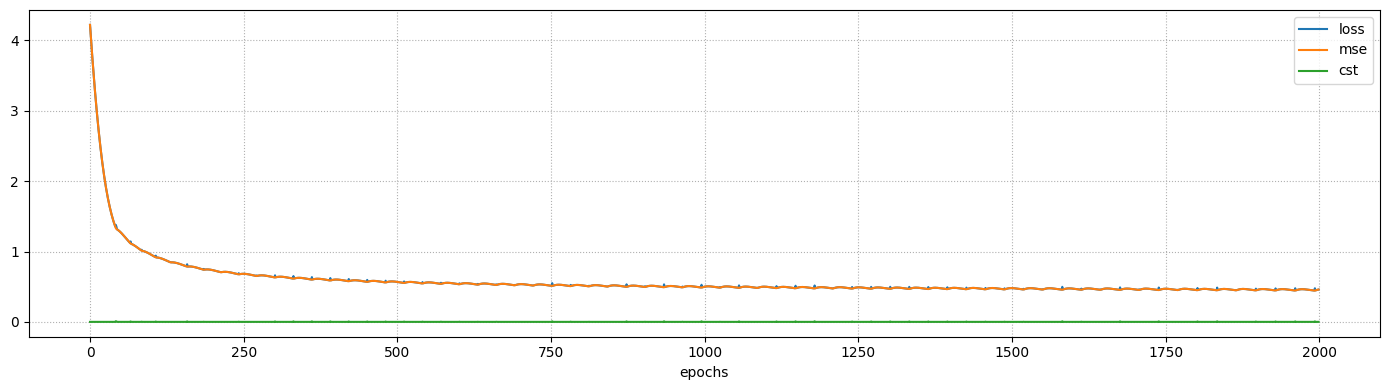

Final loss: 0.4592 (training)


In [4]:
base_pred = util.build_nn_model(input_shape=len(attributes), output_shape=1, hidden=[])
nn = util.CstDIDIModel(base_pred, attributes, protected, alpha=5, thr=didi_thr)
history = util.train_nn_model(nn, tr[attributes], tr[target], loss='mse', validation_split=0., epochs=2000, batch_size=len(tr))
util.plot_training_history(history, figsize=figsize)

## Constrained Model Evaluation

**Let's check both the prediction quality and the DIDI**

In [5]:
tr_pred = nn.predict(tr[attributes], verbose=0)
r2_tr = r2_score(tr[target], tr_pred)
ts_pred = nn.predict(ts[attributes], verbose=0)
r2_ts = r2_score(ts[target], ts_pred)
tr_DIDI = util.DIDI_r(tr, tr_pred, protected)
ts_DIDI = util.DIDI_r(ts, ts_pred, protected)

print(f'R2 score: {r2_tr:.2f} (training), {r2_ts:.2f} (test)')
print(f'DIDI: {tr_DIDI:.2f} (training), {ts_DIDI:.2f} (test)')

R2 score: 0.54 (training), 0.45 (test)
DIDI: 0.89 (training), 0.94 (test)


**The constraint is satisfied (and the accuracy reduced, as expected)**

...But _why is there some slack_ in terms of constraint satisfaction?

* If $\lambda$ were too small, we should have an infeasibility
* Otherwise, we should have optimal accuracy. Is this what is happening?

# Lagrangian Dual Framework

## Choosing Multiplier Values

**We are currently solving this problem**

$$
\operatorname{argmin}_{\theta} \mathbb{E}\left[ L(y, \hat{y}) +\lambda \max\left(0, g(\hat{y}) \right) \right] \quad\text{ with: } \hat{y} = f(x, \theta)
$$

...By using (Stochastic) _Gradient Descent_

**This is an important detail**

* A large $\lambda$ may be fine theoretically
* ...But it may cause the gradient to be _unstable_

**Therefore:**

* With a convex model, we should still reach convergence, but _slowly_
* With a non-convex model, we may end up in a poor local optimum

<div class=big>How can we deal with this?</div>

## Penalty Method

**We can think of increasing $\lambda$ gradually**

...Which leads to the classical _penalty method_

* $\lambda^{(0)} = 1$
* $\theta^{(0)} = \operatorname{argmin}_{\theta} \left\{ L(y, \hat{y}) + \lambda^{(0)T} \max(0, g(\hat{y})) \right\} \text{ with: } \hat{y} = f(x, \theta)$
* For $k = 1..n$
  - If $g(y) \leq 0$, stop
  - Otherwise $\lambda^{(k)} = r\lambda^{(k)}$, with $r \in (1, \infty)$
  - $\theta^{(k)} = \operatorname{argmin}_{\theta} \left\{ L(y, \hat{y}) + \lambda^{(k)T} \max(0, g(\hat{y})) \right\} \text{ with: } \hat{y} = f(x, \theta)$

**This can work, but there are a few issues**

* $\lambda$ grows quickly and may still become problematically large
* Early and late stages in SGD may call for _different values of $\lambda$_

## Gradient Ascent to Control the Multipliers

**A gentler approach consists in using _gradient ascent for the multipliers_**

Let's consider our modified loss:

$$
\mathcal{L}(\theta, \lambda) = L(y, f(x, \theta)) +\lambda^T \max\left(0, g(f(x, \theta)) \right)
$$

* This is actually differentiable in $\lambda$

**The gradient is also a very simple expression:**

$$
\nabla_{\lambda} \mathcal{L}(\theta, \lambda) = \max\left(0, g(f(x, \theta))\right)
$$

* For satisfied constraints, the partial derivative is 0
* For violated constraints, it is equal to the violation

## Lagrangian Dual Approach

**Therefore, we can solve our constrained ML problem**

...By alternating _gradient descent and ascent_:

* $\lambda^{(0)} = 0$
* For $k = 1..n$ (or until convergence):
  - Obtain $\lambda^{(k)}$ via an ascent step with $\nabla_{\lambda} \mathcal{L}(\lambda, \theta^{(k-1)})$
  - Obtain $\theta^{(k)}$ via a descent step with $\nabla_{\theta} \mathcal{L}(\lambda^{(k)}, \theta)$

**Technically, we are working with sub-gradients here**

* When we optimize $\lambda$ (outer optimization loop), we keep $\theta$ fixed
* ...Meaning we are going to under-estimate the gradient

Still, this is often good enough!

## Lagrangian Dual Approach

**Therefore, we can solve our constrained ML problem**

...By alternating _gradient descent and ascent_:

* $\lambda^{(0)} = 0$
* $\theta^{(0)} = \operatorname{argmin}_\theta \mathcal{L}(\lambda^{(0)}, \theta)$
* For $k = 1..n$ (or until convergence):
  - Obtain $\lambda^{(k)}$ via an ascent step with $\nabla_{\lambda} \mathcal{L}(\lambda, \theta^{(k-1)})$
  - Obtain $\theta^{(k)}$ via a descent step with $\nabla_{\theta} \mathcal{L}(\lambda^{(k)}, \theta)$

**We might still reach impractical values for $\lambda$**

...But the gentle updates will keep the gradient more stable

* At the beginning, SGD will be free to prioritize accuracy
* After some iterations, both $\theta$ and $\lambda$ will be nearly (locally) optimal

## Implementing the Lagrangian Dual Approach

**We will implement the Lagrangian dual approach via another custom model**

```python
class LagDualDIDIRegressor(MLPRegressor):
    def __init__(self, base_pred, attributes, protected, thr):
        super(LagDualDIDIRegressor, self).__init__()
        self.alpha = tf.Variable(0., name='alpha')
        ...

    def __custom_loss(self, x, y_true, sign=1): ...

    def train_step(self, data): ...
        
    def metrics(self): ...
```

* We no longer pass a fixed `alpha` weight/multiplier
* Instead we use a _trainable variable_

## Implementing the Lagrangian Dual Approach

**We move the loss function computation in a dedicated method (`__custom_loss`)**

```python
def __custom_loss(self, x, y_true, sign=1):
    y_pred = self.base_pred(x, training=True) # obtain the predictions
    mse = self.compiled_loss(y_true, y_pred) # main loss
    ymean = tf.math.reduce_mean(y_pred) # average prediction
    didi = 0 # DIDI computation
    for aidx, dom in self.protected.items():
        for val in dom:
            mask = (x[:, aidx] == val)
            didi += tf.math.abs(ymean - tf.math.reduce_mean(y_pred[mask]))
    cst = tf.math.maximum(0.0, didi - self.thr) # regularizer
    loss = mse + self.alpha * cst
    return sign*loss, mse, cst
```

* The code is the same as before
* ...Except that we can flip the loss sign via a function argument (i.e. `sign`)

## Implementing the Lagrangian Dual Approach

**In the training method, we make _two distinct gradient steps:_**

```python
    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape: # first loss (minimization)
            loss, mse, cst = self.__custom_loss(x, y_true, sign=1)
        grads = tape.gradient(loss, self.trainable_variables)
        grads[-1] = 0 * grads[-1] # null multiplier gradient
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        with tf.GradientTape() as tape: # second loss (maximization)
            loss, mse, cst = self.__custom_loss(x, y_true, sign=-1)
        grads = tape.gradient(loss, self.trainable_variables)
        for i in range(len(grads)-1): # null weight gradient
            grads[i] = 0 * grads[i]
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        ...
```

* In principle, we could even have used two distinct optimizers

## Training the Lagrangian Dual Approach

**The new approach leads _fewer oscillations at training time_**

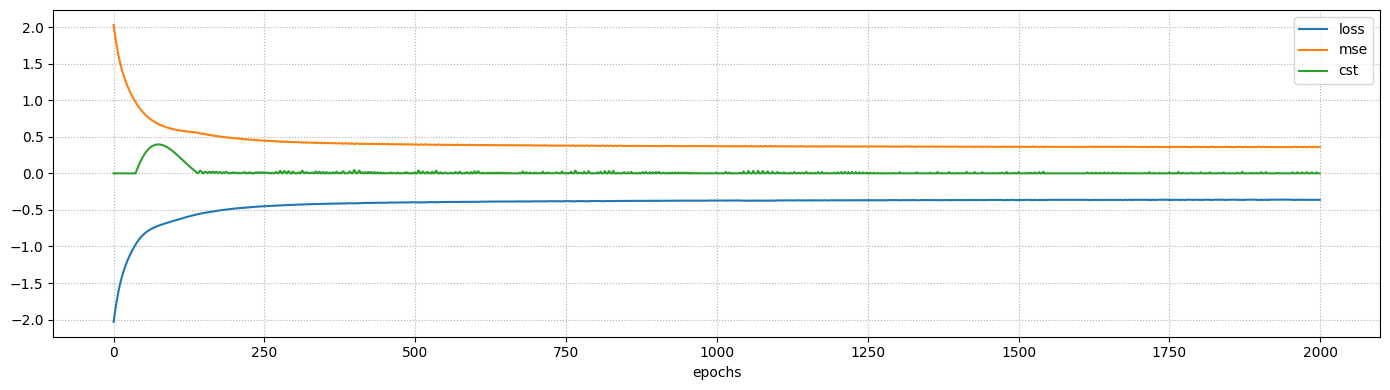

Final loss: -0.3623 (training)


In [34]:
base_pred = util.build_nn_model(input_shape=len(attributes), output_shape=1, hidden=[])
nn2 = util.LagDualDIDIModel(base_pred, attributes, protected, thr=didi_thr)
history = util.train_nn_model(nn2, tr[attributes], tr[target], loss='mse', validation_split=0., epochs=2000, batch_size=len(tr))
util.plot_training_history(history, figsize=figsize)

## Lagrangian Dual Evaluation

**Let's check the new results**

In [33]:
tr_pred2 = nn2.predict(tr[attributes], verbose=0)
r2_tr2 = r2_score(tr[target], tr_pred2)
ts_pred2 = nn2.predict(ts[attributes], verbose=0)
r2_ts2 = r2_score(ts[target], ts_pred2)
tr_DIDI2 = util.DIDI_r(tr, tr_pred2, protected)
ts_DIDI2 = util.DIDI_r(ts, ts_pred2, protected)

print(f'R2 score: {r2_tr2:.2f} (training), {r2_ts2:.2f} (test)')
print(f'DIDI: {tr_DIDI2:.2f} (training), {ts_DIDI2:.2f} (test)')

R2 score: 0.64 (training), 0.57 (test)
DIDI: 0.98 (training), 1.12 (test)


* The DIDI has the desired value (on the test set, this is only roughly true)
* ...And the prediction quality is _much higher than before_!

## Some Comments

**This is not the only approach for constrained ML**

* There approaches based on projection, pre-processing, iterative projection...
* ...And in some cases you can enforce constraints through the architecture itself

**...But it is simple and flexible**

* You just need your constraint to be differentiable
* ...And some good will to tweak the implementation

**The approach can be used also for _symbolic knowledge injection_**

* Perhaps domain experts can provide you some intuitive rule of thumbs
* You model those as constraints and take them into account at training time
* Just be careful with the weights, as in this case feasibility is not the goal